# **CSC 510 Assignment 2**

### This Jupyter Notebook file is about understanding machine learning techniques via comparing regression models in two-dimensional and three-dimensional visuals on computer-generated datasets of varying observation sizes and the "recent-grads.csv" file & "grad-students.csv" file, and using the Random Forest classification model to select the best features in the "nslkdd-version1.csv" file & "nslkdd-version2.csv"

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, functions
conf = SparkConf().setAppName("CSC 510 Assignment 2").setMaster("spark://127.0.0.1:7077")
sc = SparkContext.getOrCreate(conf)
sc

<SparkContext master=spark://127.0.0.1:7077 appName=CSC 510 Assignment 2>

In [3]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import random, numpy as np, math, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

**These methods are used to normalize and standardize data features. They will be used later in the program.**

In [5]:
def normalize_df(df, col_name):
    norm_df = df.withColumn('norm_' + col_name,
                            (df[col_name] - df.select(functions.min(col_name)).collect()[0][0])
                            / (df.select(functions.max(col_name)).collect()[0][0]
                               - df.select(functions.min(col_name)).collect()[0][0]))
    return norm_df

In [6]:
def standardize_df(df, col_name):
    std_df = df.withColumn('std_' + col_name,
                            (df[col_name] - df.select(functions.mean(col_name)).collect()[0][0])
                            / (df.select(functions.stddev(col_name)).collect()[0][0]))
    return std_df

## *Comparison of Regression Models*
### *Generated Data Points*

**Generate random data points and then convert them into a Spark SQL dataframe. Then, separate columns appropriately into numpy arrays where each row value is contained with the row class label.**

In [7]:
x1_points = np.array([random.uniform(0,5) for x in range(50)])
x2_points = np.array([random.uniform(0,5) for x in range(50)])
x3_points = np.array([random.uniform(0,10) for x in range(50)])
yy_points = np.array([0 if (y % 2 == 0) else 1 for y in range(50)])
data = np.vstack([x1_points,x2_points,x3_points,yy_points]).T
pandas_data = pd.DataFrame(data)
pyspark_data = sqlContext.createDataFrame(pandas_data)
pyspark_data.show()

+-------------------+-------------------+-------------------+---+
|                  0|                  1|                  2|  3|
+-------------------+-------------------+-------------------+---+
| 2.7338189110751814| 3.0300719008041983|   6.00895013783432|0.0|
| 3.6453949311294047| 2.4080049721039476| 0.3120039194644464|1.0|
| 0.8703217580764472|  4.863381238643155| 2.2147286049341774|0.0|
|0.14340189812604376|  3.677002990562461|  6.056380853286038|1.0|
|0.01777546951461817| 3.5578688615196885| 1.0178506295404377|0.0|
|  2.913718915772768| 0.2801022021851918|0.01684863818022131|1.0|
| 0.8660659548060395| 1.5538306874706775| 0.5137746053205172|0.0|
| 3.5947542478718435| 1.9326958263816274|  4.381186358381997|1.0|
|   4.39116819834101|  2.069023372651389| 0.4553864101867733|0.0|
|     2.507310281043|  4.779987572334774|  4.458710735084658|1.0|
| 0.6828248764618566|0.23658662931704766|  3.751808473180016|0.0|
| 1.6926327906174055|  2.172758401623012|   5.94328099395568|1.0|
| 1.604272

In [8]:
gen_x1 = np.array([(x[0],y[0]) for x,y in zip(
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('0').collect(),
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('3').collect())])
gen_x2 = np.array([(x[0],y[0]) for x,y in zip(
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('1').collect(),
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('3').collect())])
gen_x3 = np.array([(x[0],y[0]) for x,y in zip(
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('2').collect(),
    pyspark_data[(pyspark_data['3'] == 0) |
                 (pyspark_data['3'] == 1)].select('3').collect())])
gen_yy = np.array([y[0] for y in pyspark_data.select('3').collect()])
labels = [0,1]

**These are the methods used to compute regression models and then construct 2-D and 3-D visualizations of said models.**

**Standard Regression**

*1-D Data Domain*

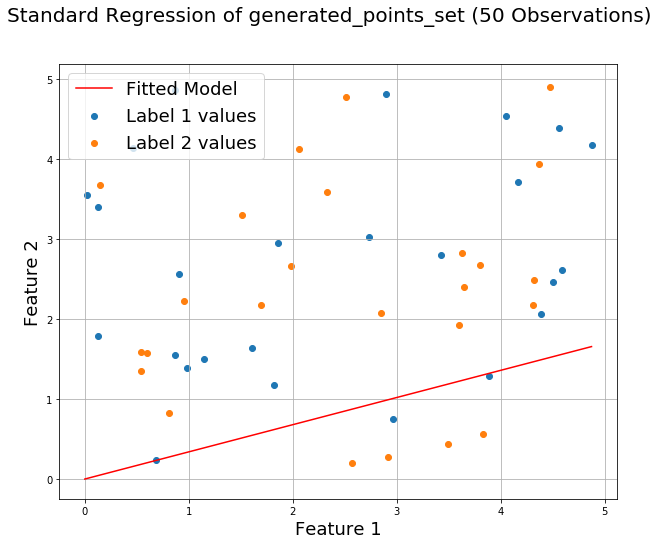

Standard regression mean square error: 0.21567114918983651
Standard regression root mean square error: 0.464404079643834


In [9]:
from sklearn.metrics import mean_squared_error

def std_reg_1D(x1,x2,y,label_vals,dataset,feat1,feat2,text_label1,text_label2):
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_label = [item[1] for item in x2]
    X = np.vstack([x1_val, x2_val]).T
    A = np.linalg.multi_dot([(X.T.dot(X)) ** -1, X.T, y])
    xt = np.array([0, np.amax(x1_val)])
    yt = A * xt
    title = ('Standard Regression of %s (%d Observations)' % (dataset, len(x1)))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
                label=text_label1 + " values")
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
                label=text_label2 + " values")
    plt.plot(xt, yt, 'r', label='Fitted Model')
    plt.xlabel(feat1, fontsize=18)
    plt.ylabel(feat2, fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/std_reg_1d_%s.jpeg" % dataset)
    plt.savefig(savefig_title)
    plt.show()
    mse = mean_squared_error([y[0], y[math.ceil(np.amax(x1_val))]], yt)
    rmse = math.sqrt(mse)
    print("Standard regression mean square error:", mse)
    print("Standard regression root mean square error:", rmse)

std_reg_1D(gen_x1,gen_x2,gen_yy,labels,"generated_points_set","Feature 1","Feature 2","Label 1", "Label 2")

2-D Data Domain

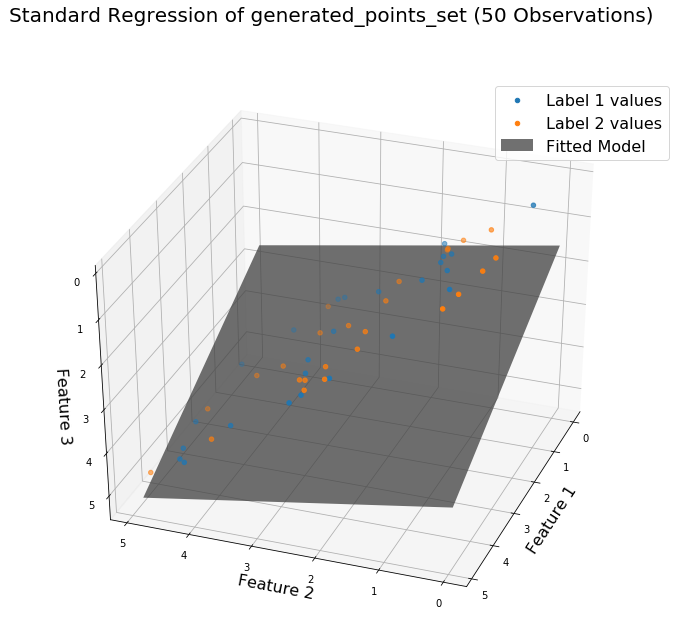

In [10]:
def std_reg_2D(x1,x2,x3,yy,label_vals,dataset,feat1,feat2,feat3,text_label1,text_label2):
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x2_label = [item[1] for item in x2]
    x3_val = np.array([item[0] for item in x3], dtype=np.float32)
    x3_label = [item[1] for item in x3]
    gs = np.amax(x1_val)
    XX = np.vstack([x1_val, x2_val, x3_val]).T
    AA = np.linalg.multi_dot([(XX.T.dot(XX)) ** -1, XX.T, yy])
    xx1 = [0,0,gs,gs]
    xx2 = [0,gs,0,gs]
    xx3 = [gs,gs,0,0]
    xxx = np.array([xx1,xx2,xx3])
    yy1 = AA.dot(xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,gs],[0,gs])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Standard Regression of %s (%d Observations)' % (dataset, len(x1)))
    figure.suptitle(title, fontsize=20)
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               label=text_label1 + " values")
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               label=text_label2 + " values")
    surf = ax.plot_surface(mg1, mg2, yy2, label='Fitted Model', color='gray', alpha=0.75)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d
    ax.legend(fontsize=16)
    ax.set_xlabel(feat1, fontsize=16)
    ax.set_ylabel(feat2, fontsize=16)
    ax.set_zlabel(feat3, fontsize=16)
    ax.view_init(-145,160)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/std_reg_2d_%s.jpeg" % dataset)
    figure.savefig(savefig_title)

std_reg_2D(gen_x1,gen_x2,gen_x3,gen_yy,labels,"generated_points_set","Feature 1","Feature 2",
           "Feature 3","Label 1","Label 2")

**Ridge Recession**

*1-D Data Domain*

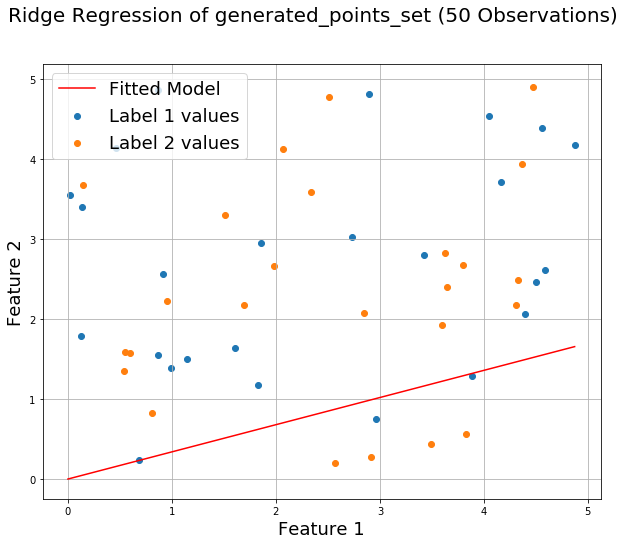

Ridge regression mean square error: 0.21536502513056796
Ridge regression root mean square error: 0.46407437456787887


In [11]:
def ridge_reg_1D(x1,x2,y,label_vals,dataset,feat1,feat2,text_label1,text_label2):
    _lambda = 0.1
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_label = [item[1] for item in x2]
    X = np.vstack([x1_val, x2_val]).T
    A = np.linalg.multi_dot([(X.T.dot(X) + _lambda) ** -1, X.T, y])
    xt = np.array([0, np.amax(x1_val)])
    yt = A * xt
    title = ('Ridge Regression of %s (%d Observations)' % (dataset, len(x1)))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
                label=text_label1 + " values")
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
                label=text_label2 + " values")
    plt.plot(xt, yt, 'r', label='Fitted Model')
    plt.xlabel(feat1, fontsize=18)
    plt.ylabel(feat2, fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/ridge_reg_1d_%s.jpeg" % dataset)
    plt.savefig(savefig_title)
    plt.show()
    mse = mean_squared_error([y[0], y[math.ceil(np.amax(x1_val))]], yt)
    rmse = math.sqrt(mse)
    print("Ridge regression mean square error:", mse)
    print("Ridge regression root mean square error:", rmse)

ridge_reg_1D(gen_x1,gen_x2,gen_yy,labels,"generated_points_set","Feature 1","Feature 2","Label 1","Label 2")

*2-D Data Domain*

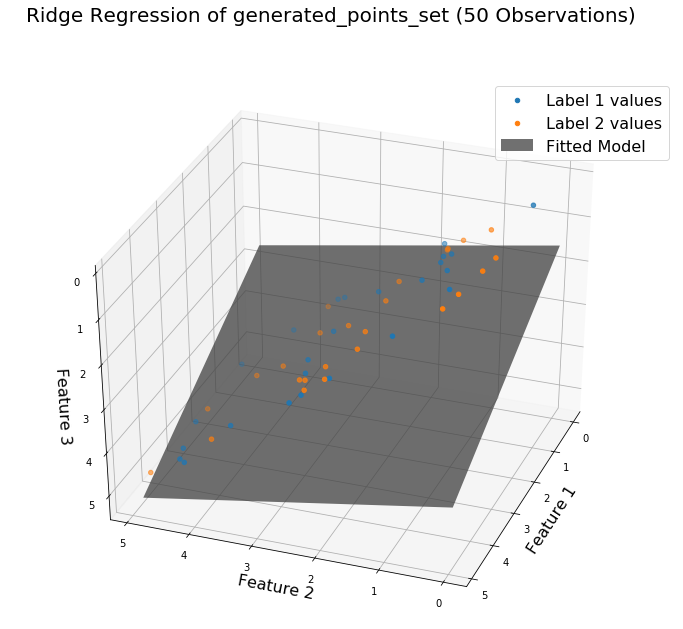

In [12]:
def ridge_reg_2D(x1,x2,x3,yy,label_vals,dataset,feat1,feat2,feat3,text_label1,text_label2):
    _lambda = 0.1
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x2_label = [item[1] for item in x2]
    x3_val = np.array([item[0] for item in x3], dtype=np.float32)
    x3_label = [item[1] for item in x3]
    gs = np.amax(x1_val)
    XX = np.vstack([x1_val,x2_val,x3_val]).T
    nn = len(np.matmul(XX.T,XX))
    AA = np.linalg.multi_dot([(XX.T.dot(XX) + (_lambda*np.eye(nn))) ** -1, XX.T, yy])
    xx1 = [0,0,gs,gs]
    xx2 = [0,gs,0,gs]
    xx3 = [gs,gs,0,0]
    xxx = np.array([xx1,xx2,xx3])
    yy1 = AA.dot(xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,gs],[0,gs])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Ridge Regression of %s (%d Observations)' % (dataset, len(x1)))
    figure.suptitle(title, fontsize=20)
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               label=text_label1 + " values")
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               label=text_label2 + " values")
    surf = ax.plot_surface(mg1, mg2, yy2, label='Fitted Model', color='gray', alpha=0.75)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d
    ax.legend(fontsize=16)
    ax.set_xlabel(feat1, fontsize=16)
    ax.set_ylabel(feat2, fontsize=16)
    ax.set_zlabel(feat3, fontsize=16)
    ax.view_init(-145,160)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/ridge_reg_2d_%s.jpeg" % dataset)
    figure.savefig(savefig_title)

ridge_reg_2D(gen_x1,gen_x2,gen_x3,gen_yy,labels,"generated_points_set","Feature 1","Feature 2",
             "Feature 3","Label 1","Label 2")

**Lasso Regression**

*1-D Data Domain*

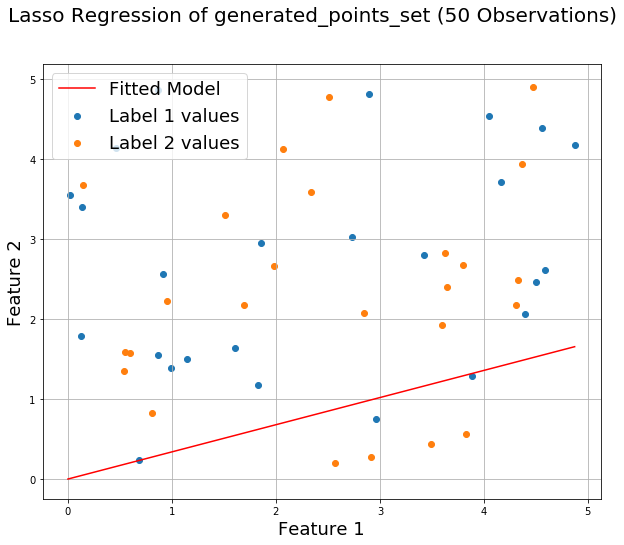

Lasso regression mean square error: 0.21478606089240904
Lasso regression root mean square error: 0.46345017088400026


In [13]:
def lasso_reg_1D(x1,x2,y,label_vals,dataset,feat1,feat2,text_label1,text_label2):
    _lambda = 0.1
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_label = [item[1] for item in x2]
    X = np.vstack([x1_val, x2_val]).T
    A1 = np.linalg.multi_dot([(X.T.dot(X) + _lambda) ** -1, X.T, y])
    S = np.sign(A1)
    A = (X.T.dot(X) ** -1).dot(X.T.dot(y) - (S * _lambda / 2))
    xt = np.array([0,np.amax(x1_val)])
    yt = A * xt
    title = ('Lasso Regression of %s (%d Observations)' % (dataset, len(x1)))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
                label=text_label1 + " values")
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
                label=text_label2 + " values")
    plt.plot(xt, yt, 'r', label='Fitted Model')
    plt.xlabel(feat1, fontsize=18)
    plt.ylabel(feat2, fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/lasso_reg_1d_%s.jpeg" % dataset)
    plt.savefig(savefig_title)
    plt.show()
    mse = mean_squared_error([y[0], y[math.ceil(np.amax(x1_val))]], yt)
    rmse = math.sqrt(mse)
    print("Lasso regression mean square error:", mse)
    print("Lasso regression root mean square error:", rmse)

lasso_reg_1D(gen_x1,gen_x2,gen_yy,labels,"generated_points_set","Feature 1","Feature 2","Label 1","Label 2")

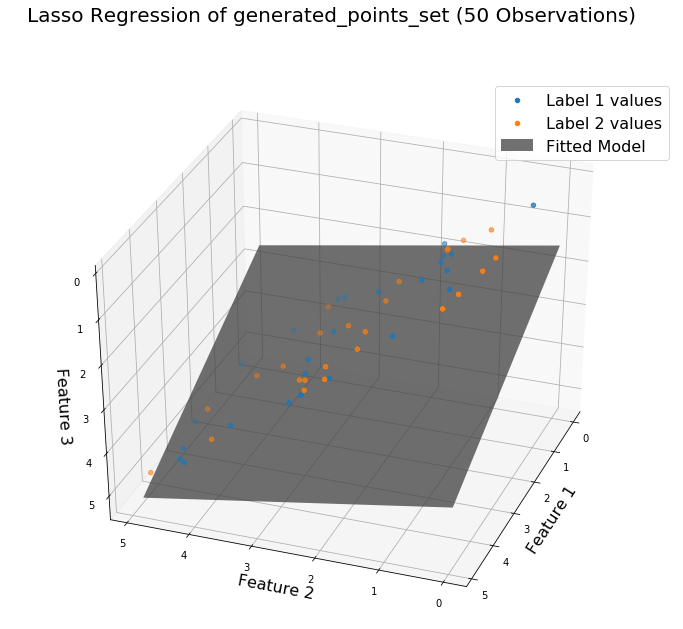

In [14]:
def lasso_reg_2D(x1,x2,x3,yy,label_vals,dataset,feat1,feat2,feat3,text_label1,text_label2):
    _lambda = 0.1
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x2_label = [item[1] for item in x2]
    x3_val = np.array([item[0] for item in x3], dtype=np.float32)
    x3_label = [item[1] for item in x3]
    gs = np.amax(x1_val)
    XX = np.vstack([x1_val, x2_val, x3_val]).T
    nn = len(XX.T.dot(XX))
    AA1 = np.linalg.multi_dot([(XX.T.dot(XX)) ** -1, XX.T, yy])
    SS = np.sign(AA1)
    AA = (XX.T.dot(XX) ** -1).dot(XX.T.dot(yy) - (SS * _lambda / 2))
    xx1 = [0,0,gs,gs]
    xx2 = [0,gs,0,gs]
    xx3 = [gs,gs,0,0]
    xxx = np.array([xx1,xx2,xx3])
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,gs],[0,gs])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Lasso Regression of %s (%d Observations)' % (dataset, len(x1)))
    figure.suptitle(title, fontsize=20)
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               label=text_label1 + " values")
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               label=text_label2 + " values")
    surf = ax.plot_surface(mg1, mg2, yy2, label='Fitted Model', color='gray', alpha=0.75)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d
    ax.legend(fontsize=16)
    ax.set_xlabel(feat1, fontsize=16)
    ax.set_ylabel(feat2, fontsize=16)
    ax.set_zlabel(feat3, fontsize=16)
    ax.view_init(-145,160)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/lasso_reg_2d_%s.jpeg" % dataset)
    figure.savefig(savefig_title)

lasso_reg_2D(gen_x1,gen_x2,gen_x3,gen_yy,labels,"generated_points_set","Feature 1","Feature 2",
             "Feature 3","Label 1","Label 2")

**Elastic-Net Regression**

*1-D Data Domain*

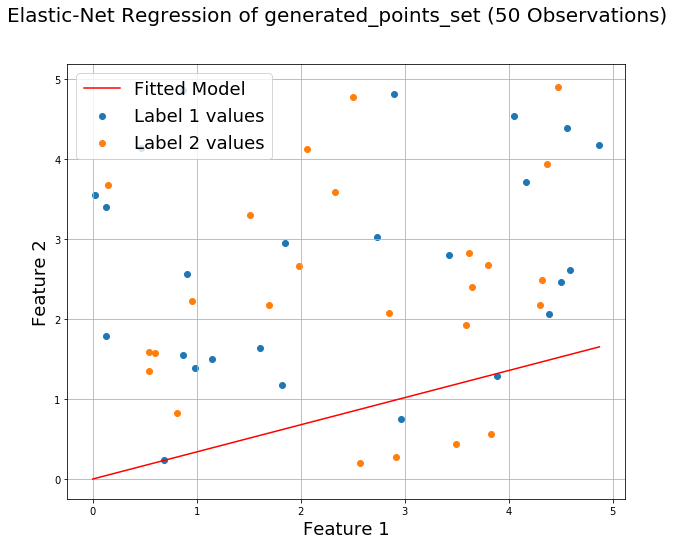

Elastic-Net regression mean square error: 0.21359842070222607
Elastic-Net regression root mean square error: 0.4621670917560294


In [15]:
def en_reg_1D(x1,x2,y,label_vals,dataset,feat1,feat2,text_label1,text_label2):
    lambda1 = 0.1
    lambda2 = 0.2
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_label = [item[1] for item in x2]
    X = np.vstack([x1_val, x2_val]).T
    A1 = np.linalg.multi_dot([(X.T.dot(X)) ** -1, X.T, y])
    S = np.sign(A1)
    A = ((X.T.dot(X) + lambda1) ** -1).dot(X.T.dot(y) - (S * lambda2 / 2))
    xt = np.array([0,np.amax(x1_val)])
    yt = A * xt
    title = ('Elastic-Net Regression of %s (%d Observations)' % (dataset, len(x1)))
    plt.figure(figsize=(10,8)).suptitle(title, fontsize=20)
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
                label=text_label1 + " values")
    plt.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
                [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
                label=text_label2 + " values")
    plt.plot(xt, yt, 'r', label='Fitted Model')
    plt.xlabel(feat1, fontsize=18)
    plt.ylabel(feat2, fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=18)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/en_reg_1d_%s.jpeg" % dataset)
    plt.savefig(savefig_title)
    plt.show()
    mse = mean_squared_error([y[0], y[math.ceil(np.amax(x1_val))]], yt)
    rmse = math.sqrt(mse)
    print("Elastic-Net regression mean square error:", mse)
    print("Elastic-Net regression root mean square error:", rmse)

en_reg_1D(gen_x1,gen_x2,gen_yy,labels,"generated_points_set","Feature 1","Feature 2","Label 1","Label 2")

*2-D Data Domain*

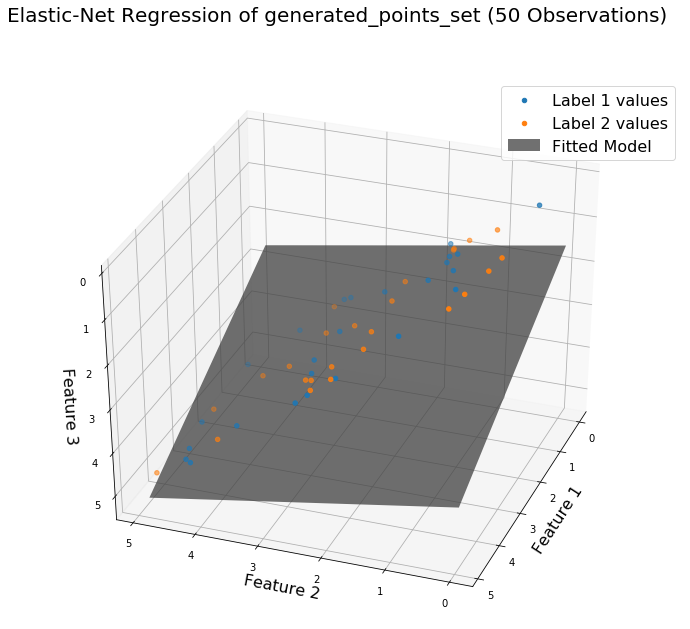

In [16]:
def en_reg_2D(x1,x2,x3,yy,label_vals,dataset,feat1,feat2,feat3,text_label1,text_label2):
    lambda1 = 0.1
    lambda2 = 0.2
    x1_val = np.array([item[0] for item in x1], dtype=np.float32)
    x1_label = [item[1] for item in x1]
    x2_val = np.array([item[0] for item in x2], dtype=np.float32)
    x2_label = [item[1] for item in x2]
    x3_val = np.array([item[0] for item in x3], dtype=np.float32)
    x3_label = [item[1] for item in x3]
    gs = np.amax(x1_val)
    XX = np.vstack([x1_val, x2_val, x3_val]).T
    nn = len(XX.T.dot(XX))
    AA1 = np.linalg.multi_dot([(XX.T.dot(XX)) ** -1, XX.T, yy])
    SS = np.sign(AA1)
    AA = ((XX.T.dot(XX) + (lambda1 * np.eye(nn))) ** -1).dot(XX.T.dot(yy) - (SS * lambda2 / 2))
    xx1 = [0,0,gs,gs]
    xx2 = [0,gs,0,gs]
    xx3 = [gs,gs,0,0]
    xxx = np.array([xx1,xx2,xx3])
    yy1 = np.matmul(AA,xxx)
    yy2 = np.reshape(yy1,(2,2))
    mg1,mg2 = np.meshgrid([0,gs],[0,gs])
    figure = plt.figure(figsize=(12,10))
    ax = figure.add_subplot(111, projection='3d')
    title = ('Elastic-Net Regression of %s (%d Observations)' % (dataset, len(x1)))
    figure.suptitle(title, fontsize=20)
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[0]],
               label=text_label1 + " values")
    ax.scatter([item[0] for item in zip(x1_val, x1_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               [item[0] for item in zip(x2_val, x2_label) if item[1] == label_vals[1]],
               label=text_label2 + " values")
    surf = ax.plot_surface(mg1, mg2, yy2, label='Fitted Model', color='gray', alpha=0.75)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d
    ax.legend(fontsize=16)
    ax.set_xlabel(feat1, fontsize=16)
    ax.set_ylabel(feat2, fontsize=16)
    ax.set_zlabel(feat3, fontsize=16)
    ax.view_init(-145,160)
    savefig_title = ("../../docs/CSC510_Assignment2_docs/report_plots/en_reg_2d_%s.jpeg" % dataset)
    figure.savefig(savefig_title)

en_reg_2D(gen_x1,gen_x2,gen_x3,gen_yy,labels,"generated_points_set","Feature 1","Feature 2",
          "Feature 3","Label 1","Label 2")

### *Graduate Student Data Points*

In [17]:
recent_grads = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/recent-grads.csv",
                                   inferSchema="true", header=True)
grads = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/grad-students.csv",
                            inferSchema="true", header=True)

**Finding the numerical feature values in the recent graduate students and graduate students datasets.**

In [18]:
recent_feats = [dt[0] for dt in recent_grads.dtypes if dt[1] == 'int' or dt[1] == 'double']
grad_feats = [dt[0] for dt in grads.dtypes if dt[1] == 'int' or dt[1] == 'double']
print(recent_feats)
print(grad_feats)

['Rank', 'Major_code', 'Total', 'Men', 'Women', 'ShareWomen', 'Sample_size', 'Employed', 'Full_time', 'Part_time', 'Full_time_year_round', 'Unemployed', 'Unemployment_rate', 'Median', 'P25th', 'P75th', 'College_jobs', 'Non_college_jobs', 'Low_wage_jobs']
['Major_code', 'Grad_total', 'Grad_sample_size', 'Grad_employed', 'Grad_full_time_year_round', 'Grad_unemployed', 'Grad_unemployment_rate', 'Grad_P25', 'Nongrad_total', 'Nongrad_employed', 'Nongrad_full_time_year_round', 'Nongrad_unemployed', 'Nongrad_unemployment_rate', 'Nongrad_P25', 'Grad_share', 'Grad_premium']


**Find the most popular majors in the datasets and use them as the two labels that will be utilized in the regression analysis.**

In [19]:
pop_major_rg = [item[0] for item in recent_grads.groupby(recent_grads.Major_category)
                .agg(functions.sum('Total').alias('Popularity')).orderBy('Popularity', ascending=False)
                .collect()][:2]
pop_major_g = [item[0] for item in grads.groupby(grads.Major_category)
               .agg(functions.sum('Grad_total').alias('Popularity')).orderBy('Popularity', ascending=False)
               .collect()][:2]
print(pop_major_rg)
print(pop_major_g)

['Business', 'Humanities & Liberal Arts']
['Education', 'Humanities & Liberal Arts']


**Map each string label to an index value.**

In [20]:
from pyspark.ml.feature import StringIndexer

def str_idx_df(df, col_name):
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_index")
    return indexer.fit(df).transform(df)

recent_grads = str_idx_df(recent_grads, 'Major_category')
grads = str_idx_df(grads, 'Major_category')

**Normalize the numerical features that will be used in regression, then separate them into numpy arrays that contain row values along with the row label.**

*Note: Only observations that belong to either sets' two most popular majors will be used.*

In [21]:
recent_grads = normalize_df(recent_grads,'Employed')
recent_grads = normalize_df(recent_grads,'Unemployed')
recent_grads = normalize_df(recent_grads,'Unemployment_rate')
recent_grads = normalize_df(recent_grads,'Major_category_index')

grads = normalize_df(grads,'Grad_employed')
grads = normalize_df(grads,'Grad_unemployed')
grads = normalize_df(grads,'Grad_unemployment_rate')
grads = normalize_df(grads,'Major_category_index')

In [22]:
rg_x1 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('norm_Employed').collect(),
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('Major_category').collect())])
rg_x2 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('norm_Unemployed').collect(),
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('Major_category').collect())])
rg_x3 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('norm_Unemployment_rate').collect(),
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('Major_category').collect())])
rg_yy = np.array([idx[0] for idx,maj in zip(
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('norm_Major_category_index').collect(),
    recent_grads[(recent_grads.Major_category == pop_major_rg[0]) |
                 (recent_grads.Major_category == pop_major_rg[1])].select('Major_category').collect())],
                 dtype=np.float32)

g_x1 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('norm_Grad_employed').collect(),
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('Major_category').collect())])
g_x2 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('norm_Grad_unemployed').collect(),
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('Major_category').collect())])
g_x3 = np.array([(emp[0],maj[0]) for emp,maj in zip(
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('norm_Grad_unemployment_rate').collect(),
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('Major_category').collect())])
g_yy = np.array([idx[0] for idx,maj in zip(
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('norm_Major_category_index').collect(),
    grads[(grads.Major_category == pop_major_g[0]) |
          (grads.Major_category == pop_major_g[1])].select('Major_category').collect())],
                dtype=np.float32)

**Standard Regression**

*1-D Data Domain*

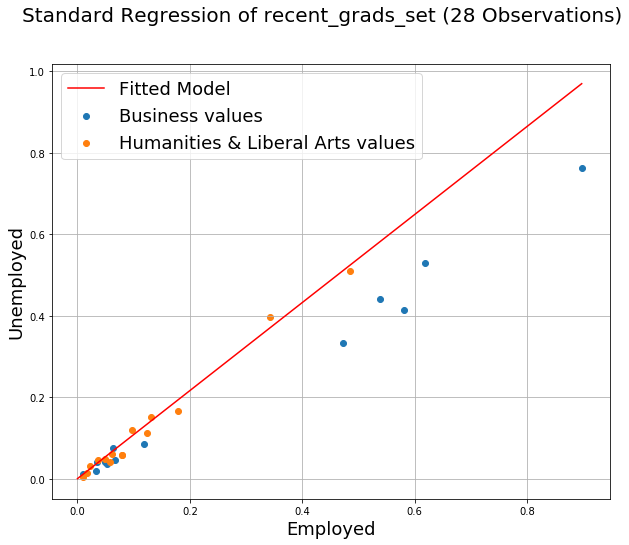

Standard regression mean square error: 0.28275369877188705
Standard regression root mean square error: 0.5317458968077582


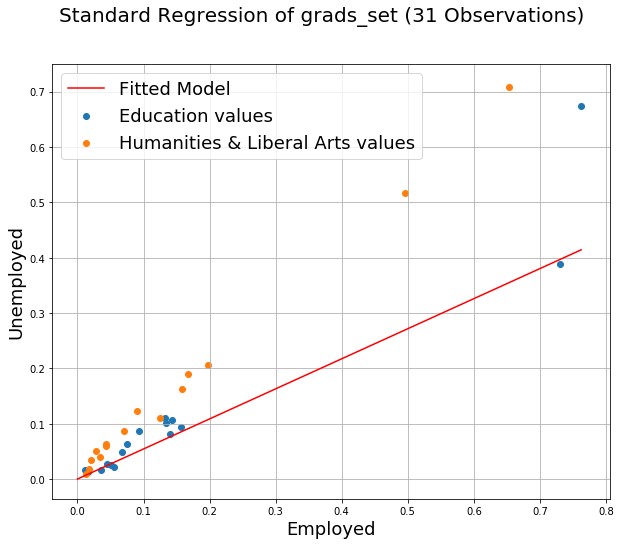

Standard regression mean square error: 0.048308697437591266
Standard regression root mean square error: 0.21979239622332541


In [23]:
std_reg_1D(rg_x1,rg_x2,rg_yy,pop_major_rg,"recent_grads_set","Employed","Unemployed",
           pop_major_rg[0],pop_major_rg[1])
std_reg_1D(g_x1,g_x2,g_yy,pop_major_g,"grads_set","Employed","Unemployed",pop_major_g[0],pop_major_g[1])

*2-D Data Domain*

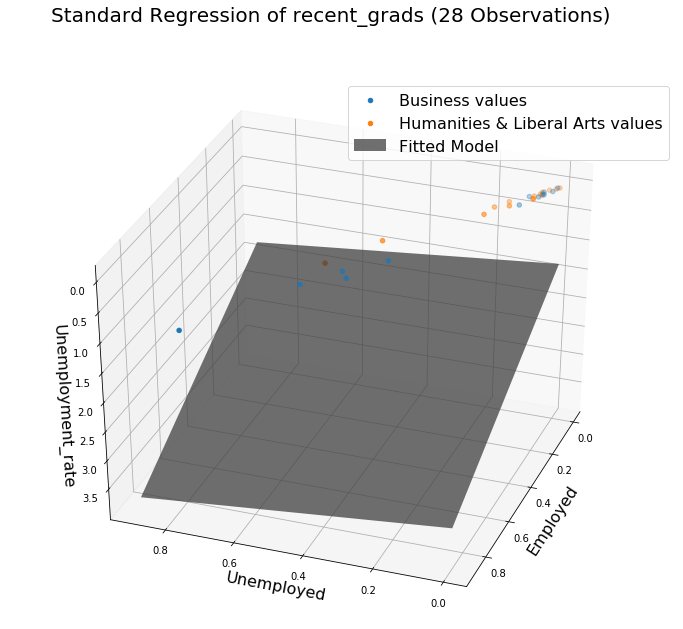

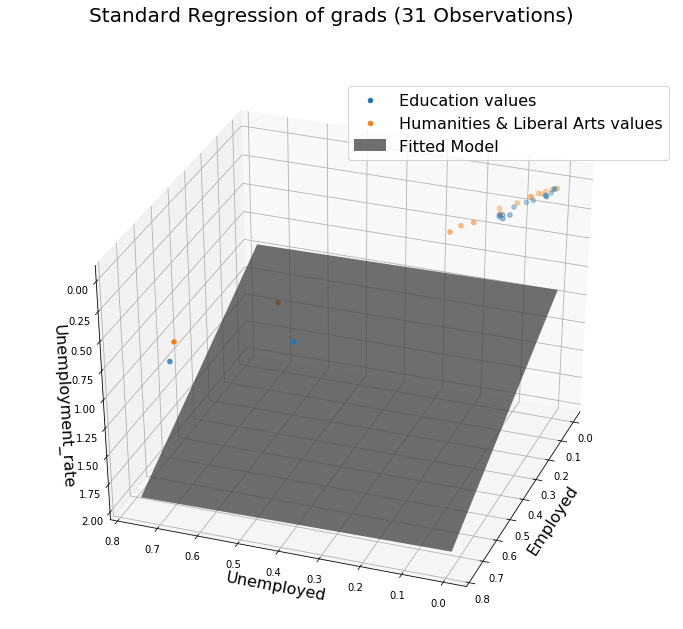

In [24]:
std_reg_2D(rg_x1,rg_x2,rg_x3,rg_yy,pop_major_rg,"recent_grads","Employed","Unemployed",
           "Unemployment_rate",pop_major_rg[0],pop_major_rg[1])

std_reg_2D(g_x1,g_x2,g_x3,g_yy,pop_major_g,"grads","Employed","Unemployed",
           "Unemployment_rate",pop_major_g[0],pop_major_g[1])

**Ridge Regression**

*1-D Data Domain*

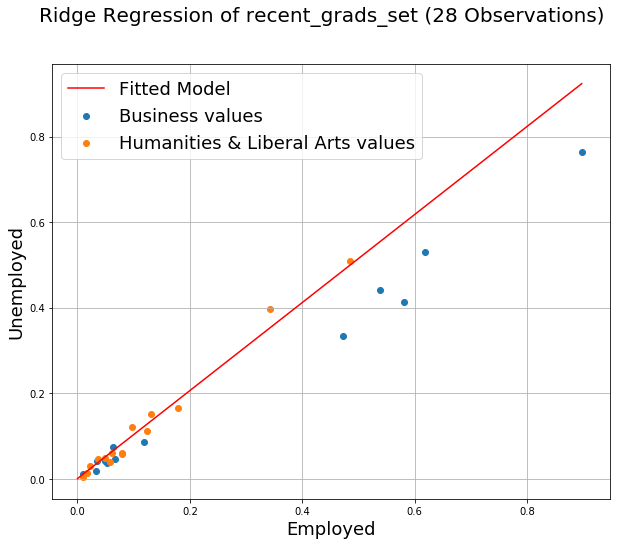

Ridge regression mean square error: 0.25140881690609745
Ridge regression root mean square error: 0.5014068377137446


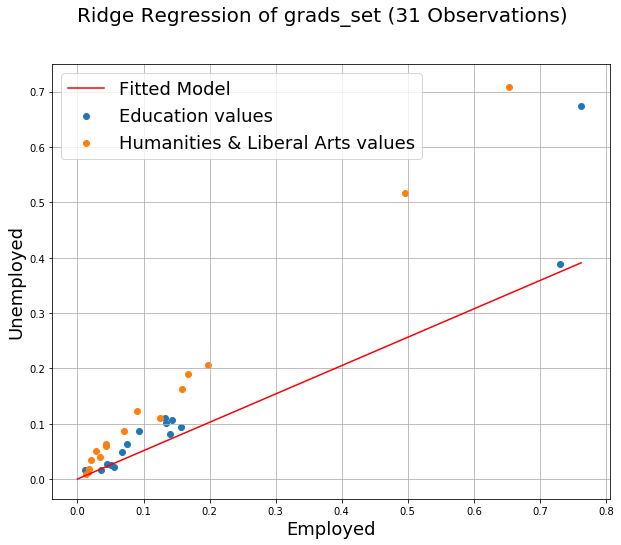

Ridge regression mean square error: 0.04199695293339806
Ridge regression root mean square error: 0.20493158110305512


In [25]:
ridge_reg_1D(rg_x1,rg_x2,rg_yy,pop_major_rg,"recent_grads_set","Employed","Unemployed",
             pop_major_rg[0],pop_major_rg[1])

ridge_reg_1D(g_x1,g_x2,g_yy,pop_major_g,"grads_set","Employed","Unemployed",pop_major_g[0],pop_major_g[1])

*2-D Data Domain*

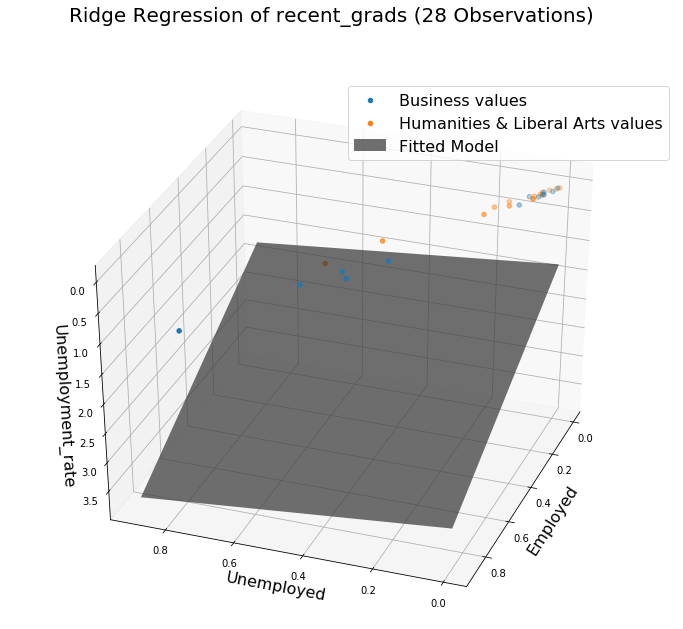

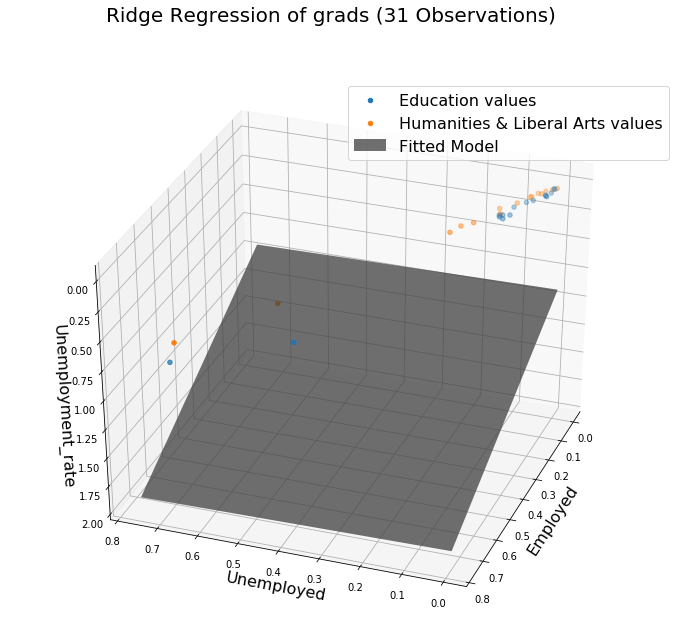

In [26]:
ridge_reg_2D(rg_x1,rg_x2,rg_x3,rg_yy,pop_major_rg,"recent_grads","Employed","Unemployed",
             "Unemployment_rate",pop_major_rg[0],pop_major_rg[1])

ridge_reg_2D(g_x1,g_x2,g_x3,g_yy,pop_major_g,"grads","Employed","Unemployed",
             "Unemployment_rate",pop_major_g[0],pop_major_g[1])

**Lasso Regression**

*1-D Data Domain*

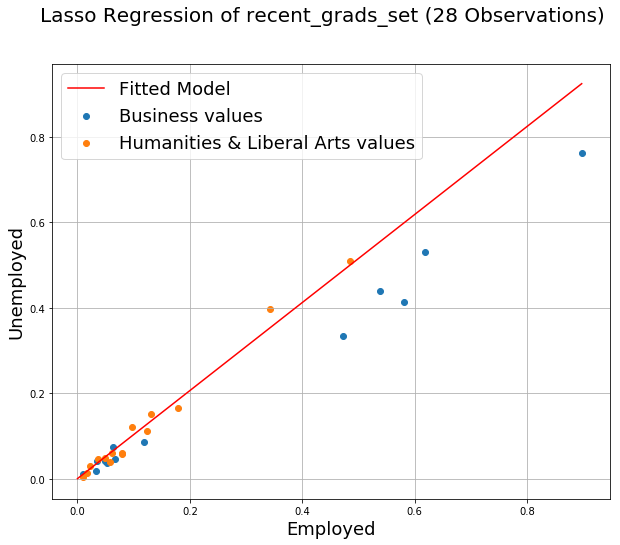

Lasso regression mean square error: 0.2522480064144403
Lasso regression root mean square error: 0.5022429754754568


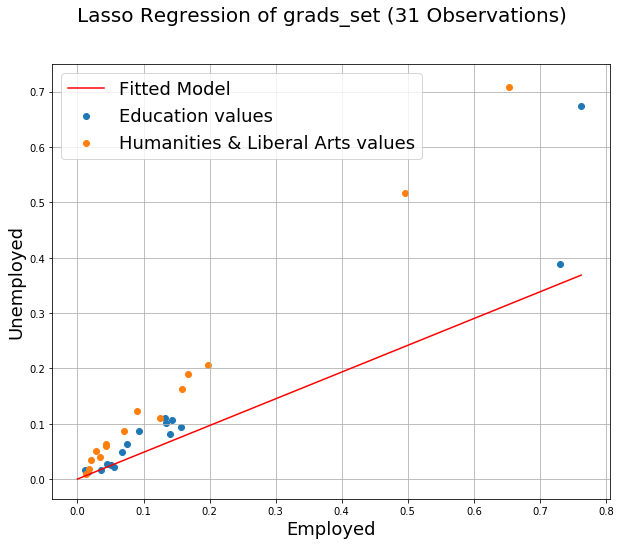

Lasso regression mean square error: 0.036511896114731004
Lasso regression root mean square error: 0.19108086276425226


In [27]:
lasso_reg_1D(rg_x1,rg_x2,rg_yy,pop_major_rg,"recent_grads_set","Employed","Unemployed",
             pop_major_rg[0],pop_major_rg[1])

lasso_reg_1D(g_x1,g_x2,g_yy,pop_major_g,"grads_set","Employed","Unemployed",pop_major_g[0],pop_major_g[1])

*2-D Data Domain*

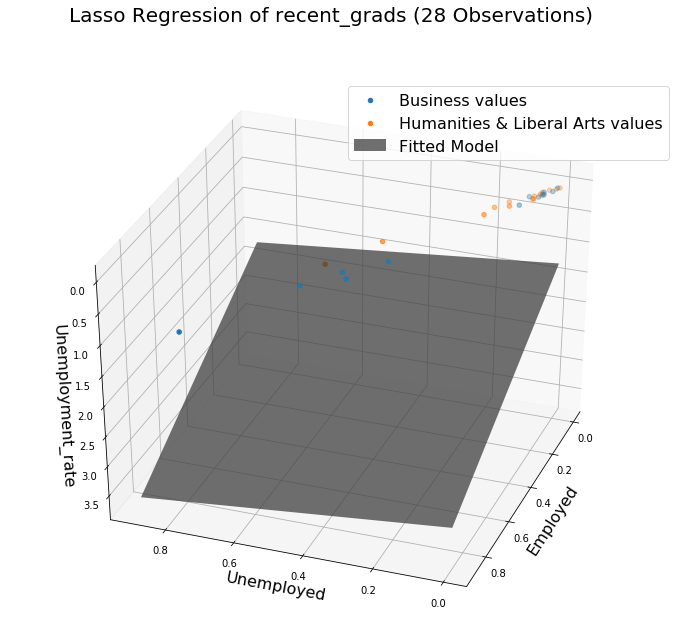

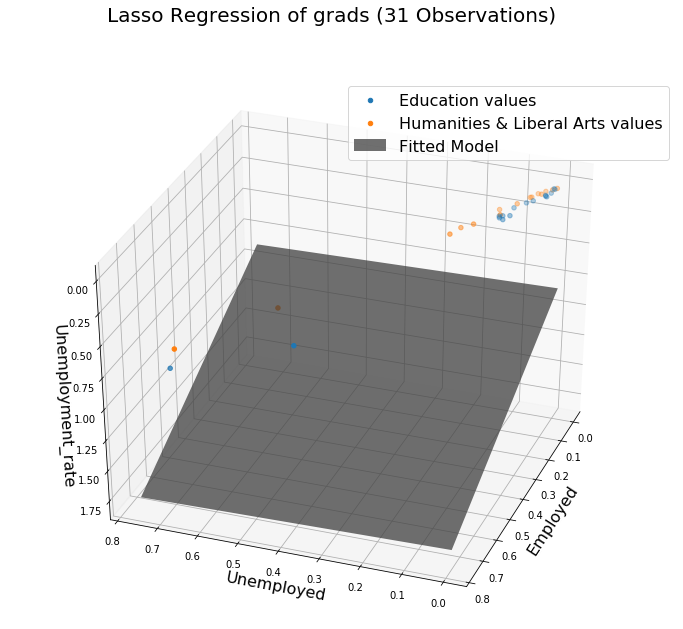

In [28]:
lasso_reg_2D(rg_x1,rg_x2,rg_x3,rg_yy,pop_major_rg,"recent_grads","Employed","Unemployed",
             "Unemployment_rate",pop_major_rg[0],pop_major_rg[1])

lasso_reg_2D(g_x1,g_x2,g_x3,g_yy,pop_major_g,"grads","Employed","Unemployed",
             "Unemployment_rate",pop_major_g[0],pop_major_g[1])

**Elastic-Net Regression**

*1-D Data Domain*

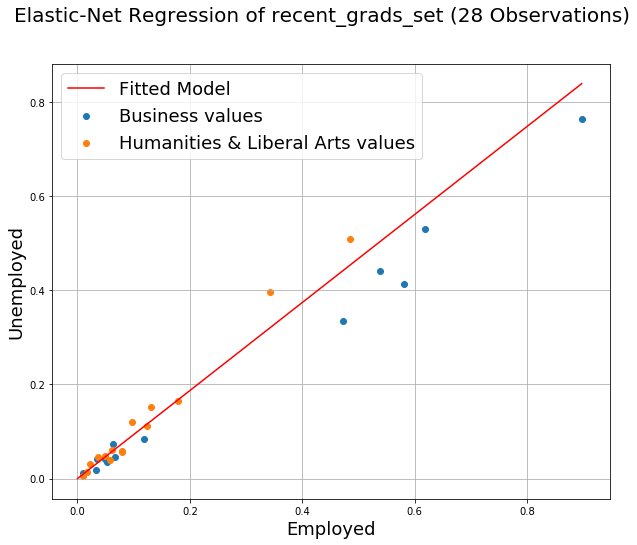

Elastic-Net regression mean square error: 0.19897567981567654
Elastic-Net regression root mean square error: 0.44606690060536497


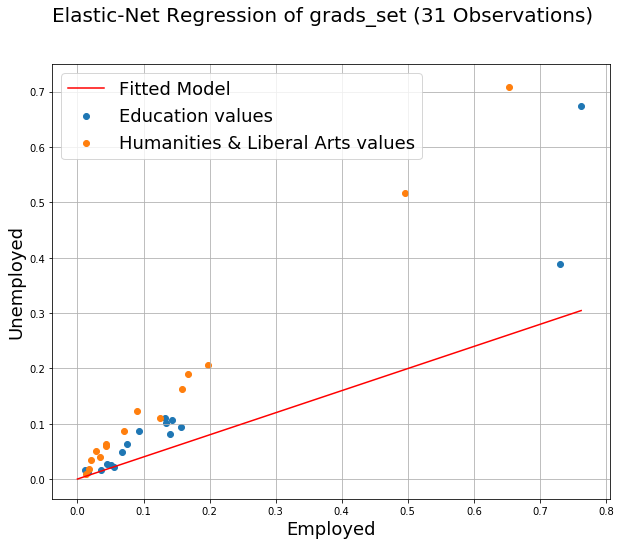

Elastic-Net regression mean square error: 0.023515185940304374
Elastic-Net regression root mean square error: 0.15334662024415266


In [29]:
en_reg_1D(rg_x1,rg_x2,rg_yy,pop_major_rg,"recent_grads_set","Employed","Unemployed",
          pop_major_rg[0],pop_major_rg[1])

en_reg_1D(g_x1,g_x2,g_yy,pop_major_g,"grads_set","Employed","Unemployed",pop_major_g[0],pop_major_g[1])

*2-D Data Domain*

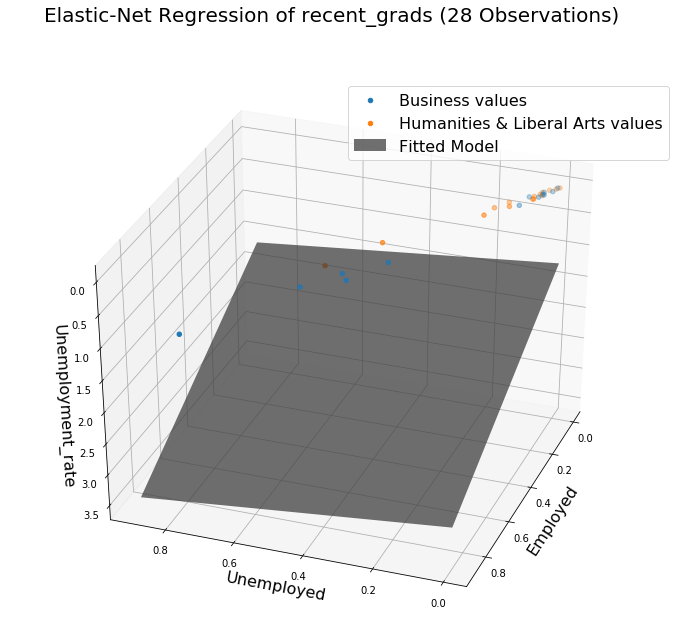

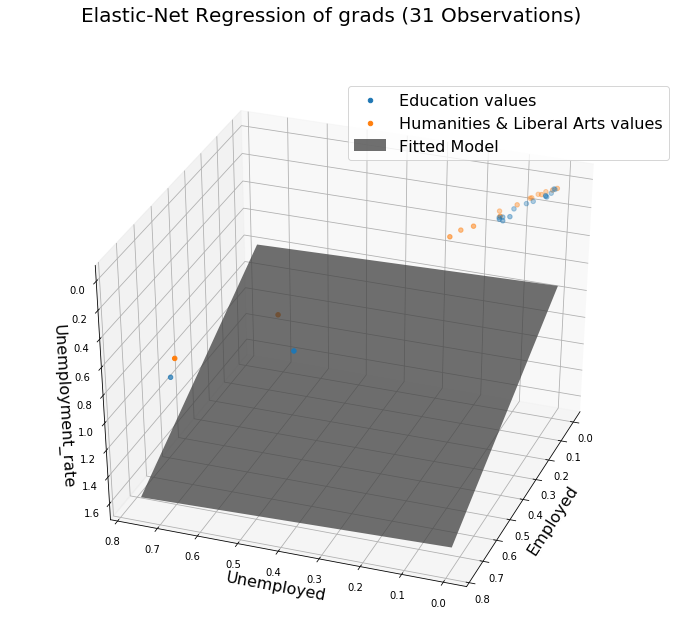

In [30]:
en_reg_2D(rg_x1,rg_x2,rg_x3,rg_yy,pop_major_rg,"recent_grads","Employed","Unemployed",
          "Unemployment_rate",pop_major_rg[0],pop_major_rg[1])

en_reg_2D(g_x1,g_x2,g_x3,g_yy,pop_major_g,"grads","Employed","Unemployed",
          "Unemployment_rate",pop_major_g[0],pop_major_g[1])

## *Network Intrusion Dataset and Random Forest*

In [31]:
v1 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version1.csv",
                         inferSchema="true", header=True).na.drop()
v2 = sqlContext.read.csv("../../data/CSC-510_Assignment2_Data/nslkdd-version2.csv",
                         inferSchema="true", header=True).na.drop()

**Mapping the string labels in nslkdd-version1.csv to index values, then labeling the network traffic types in both datasets as either normal traffic or attack traffic.**

In [33]:
print("Number of network traffic types in nslkdd-version1:", v1.select("a42").distinct().count())
print("Number of network traffic types in nslkdd-version2:", v2.select("a42").distinct().count())
v1 = str_idx_df(v1,"a42")

Number of network traffic types in nslkdd-version1: 22
Number of network traffic types in nslkdd-version2: 22


In [34]:
def traffic_label(frame, frame_label):
    temp_frame = frame.withColumn("label", functions.when(frame[frame_label] == 0, 0)
                                  .otherwise(1))
    return temp_frame

In [35]:
v1 = traffic_label(v1, "a42_index")
v2 = traffic_label(v2, "a42")

**The number of observations in the datasets and the number of observations per traffic category.**

In [32]:
print("Number of nslkdd-version1.csv observations:", v1.count())
print("Number of nslkdd-version2.csv observations:", v2.count())

Number of nslkdd-version1.csv observations: 25192
Number of nslkdd-version2.csv observations: 25192


In [36]:
print("Number of normal traffic observations in nslkdd-version1:",
      len([row for row in v1.select('label').collect() if row[0] == 0]))
print("Number of attack traffic observations in nslkdd-version1:",
      len([row for row in v1.select('label').collect() if row[0] == 1]))
print("Number of normal traffic observations in nslkdd-version2:",
      len([row for row in v2.select('label').collect() if row[0] == 0]))
print("Number of attack traffic observations in nslkdd-version2:",
      len([row for row in v2.select('label').collect() if row[0] == 1]))

Number of normal traffic observations in nslkdd-version1: 13449
Number of attack traffic observations in nslkdd-version1: 11743
Number of normal traffic observations in nslkdd-version2: 13449
Number of attack traffic observations in nslkdd-version2: 11743


**Finding the numerical feature values in the dataset.**

In [37]:
v1_feats = [c[0] for c in v1.dtypes if (c[1] == "int" or c[1] == "double") and c[0] != 'label']
v2_feats = [c[0] for c in v2.dtypes if (c[1] == "int" or c[1] == "double") and c[0] != 'label']

**Normalize and standardize the numerical features in both datasets, then dropping all non-numerical, non-normalized, and non-standardized columns from both dataframes.**

In [38]:
for col,idx in zip(v1_feats, range(len(v1_feats))):
    v1 = normalize_df(v1, col)
    v1 = standardize_df(v1, "norm_" + col)
    
for col,idx in zip(v2_feats, range(len(v2_feats))):
    v2 = normalize_df(v2, col)
    v2 = standardize_df(v2, "norm_" + col)

In [39]:
v1_feats = ["std_norm_" + feat for feat in v1_feats]
v2_feats = ["std_norm_" + feat for feat in v2_feats]

In [40]:
for col in v1.columns:
    if (col not in v1_feats) and (col != 'label'):
        v1 = v1.drop(col)

for col in v2.columns:
    if (col not in v2_feats) and (col != 'label'):
        v2 = v2.drop(col)

**Basic statistical information about each column in the current dataframes.**

In [41]:
for col in v1_feats:
    v1.describe([col]).show()

+-------+--------------------+
|summary|         std_norm_a1|
+-------+--------------------+
|  count|               25192|
|   mean|2.787156906596288...|
| stddev|  0.9999999999999974|
|    min|-0.11354840373624064|
|    max|  15.840708921459054|
+-------+--------------------+

+-------+--------------------+
|summary|         std_norm_a5|
+-------+--------------------+
|  count|               25192|
|   mean|1.352076337212951...|
| stddev|  0.9999999999999926|
|    min|-0.01009232358399...|
|    max|  158.32250875609566|
+-------+--------------------+

+-------+--------------------+
|summary|         std_norm_a6|
+-------+--------------------+
|  count|               25192|
|   mean|6.696313566452041...|
| stddev|  1.0000000000000036|
|    min|-0.03930900525596...|
|    max|   57.95172266568724|
+-------+--------------------+

+-------+--------------------+
|summary|         std_norm_a7|
+-------+--------------------+
|  count|               25192|
|   mean|-3.00753344461587...|
| std

+-------+--------------------+
|summary|        std_norm_a34|
+-------+--------------------+
|  count|               25192|
|   mean|-4.85192449711930...|
| stddev|  1.0000000000000024|
|    min|  -1.157807882934174|
|    max|  1.0696418299526567|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a35|
+-------+--------------------+
|  count|               25192|
|   mean|6.036156146737657...|
| stddev|  0.9999999999999986|
|    min| -0.4409317447178356|
|    max|   4.901202190545897|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a36|
+-------+--------------------+
|  count|               25192|
|   mean|-4.26166525060759...|
| stddev|  0.9999999999999994|
|    min| -0.4781735993567678|
|    max|  2.7647198557099855|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a37|
+-------+--------------------+
|  count|               25192|
|   mean|2.039945344715223...|
| std

In [42]:
for col in v2_feats:
    v2.describe([col]).show()

+-------+--------------------+
|summary|         std_norm_a7|
+-------+--------------------+
|  count|               25192|
|   mean|-3.00753344461587...|
| stddev|  0.9999999999999978|
|    min|-0.00891029933773...|
|    max|  112.22522015881773|
+-------+--------------------+

+-------+--------------------+
|summary|         std_norm_a8|
+-------+--------------------+
|  count|               25192|
|   mean|1.925945201280417...|
| stddev|  0.9999999999999918|
|    min|-0.09122136504340117|
|    max|  11.437450682649052|
+-------+--------------------+

+-------+--------------------+
|summary|         std_norm_a9|
+-------+--------------------+
|  count|               25192|
|   mean|-3.00753344461587...|
| stddev|  0.9999999999999978|
|    min|-0.00891029933773...|
|    max|  112.22522015881773|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a10|
+-------+--------------------+
|  count|               25192|
|   mean|1.925945201280417...|
| std

+-------+--------------------+
|summary|        std_norm_a37|
+-------+--------------------+
|  count|               25192|
|   mean|2.039945344715223...|
| stddev|  0.9999999999999953|
|    min| -0.2879877479897717|
|    max|   8.755650340513226|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a38|
+-------+--------------------+
|  count|               25192|
|   mean|-1.20571842267214...|
| stddev|  1.0000000000000013|
|    min| -0.6417913327309993|
|    max|  1.6038026569131398|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a39|
+-------+--------------------+
|  count|               25192|
|   mean|-1.23947110646461...|
| stddev|  0.9999999999999949|
|    min| -0.6273522954519803|
|    max|  1.6144215516613767|
+-------+--------------------+

+-------+--------------------+
|summary|        std_norm_a40|
+-------+--------------------+
|  count|               25192|
|   mean|-2.65125242250058...|
| std

**In the nslkdd-version1.csv dataframe, two numerical features were found to have null values in their basic statistics, so they are not helpful in classification and must be dropped as well.**

In [43]:
v1 = v1.drop('std_norm_a20','std_norm_a21')
v1_feats.remove('std_norm_a20')
v1_feats.remove('std_norm_a21')

In [44]:
print("Number of numerical features in nslkdd-version1:",
      len(v1_feats))
print("\nNumerical features in nslkdd-version1:",
      v1_feats)
print('\n--------------------------------------------------------------------------------------------------')
print("\nNumber of numerical features in nslkdd-version2:",
      len(v2_feats))
print("\nNumerical features in nslkdd-version2:",
      v2_feats)

Number of numerical features in nslkdd-version1: 37

Numerical features in nslkdd-version1: ['std_norm_a1', 'std_norm_a5', 'std_norm_a6', 'std_norm_a7', 'std_norm_a8', 'std_norm_a9', 'std_norm_a10', 'std_norm_a11', 'std_norm_a12', 'std_norm_a13', 'std_norm_a14', 'std_norm_a15', 'std_norm_a16', 'std_norm_a17', 'std_norm_a18', 'std_norm_a19', 'std_norm_a22', 'std_norm_a23', 'std_norm_a24', 'std_norm_a25', 'std_norm_a26', 'std_norm_a27', 'std_norm_a28', 'std_norm_a29', 'std_norm_a30', 'std_norm_a31', 'std_norm_a32', 'std_norm_a33', 'std_norm_a34', 'std_norm_a35', 'std_norm_a36', 'std_norm_a37', 'std_norm_a38', 'std_norm_a39', 'std_norm_a40', 'std_norm_a41', 'std_norm_a42_index']

--------------------------------------------------------------------------------------------------

Number of numerical features in nslkdd-version2: 36

Numerical features in nslkdd-version2: ['std_norm_a7', 'std_norm_a8', 'std_norm_a9', 'std_norm_a10', 'std_norm_a11', 'std_norm_a12', 'std_norm_a13', 'std_norm_a1

Balance both datasets before classifying data.

In [68]:
def create_df_sample(df):
    temp1 = df.filter(df['label'] == 0)
    temp2 = df.filter(df['label'] == 1)
    temp1 = temp1.sample(True, (temp2.count() / temp1.count()), 100)
    return temp1.union(temp2)
    
v1 = create_df_sample(v1)
v2 = create_df_sample(v2)

**This is the method contains the Random Forest classifier, the binary classification evaluator, and the cross-validator. Then it returns an array of each column's importance from least to greatest, the evaluator error value, and the 10-Fold cross-validation error value.**

In [69]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def rand_forest_best_features(features, frame, frame_label):
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
    frame_temp = vector_assembler.transform(frame)
    
    for col in frame.columns:
        if col != frame_label:
            frame_temp = frame_temp.drop(col)
    
    (train, test) = frame_temp.randomSplit([0.8, 0.2], seed=100)
    rf = RandomForestClassifier(labelCol=frame_label, featuresCol="features", numTrees=5)
    model = rf.fit(train)
    pred = model.transform(test)
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(pred)
    paramGrid = (ParamGridBuilder()
                 .addGrid(rf.maxDepth, [2,4,6])
                 .addGrid(rf.maxBins,[20,60])
                 .addGrid(rf.numTrees,[5,20])
                 .build())
    cv = CrossValidator(estimator=rf,
                        estimatorParamMaps=paramGrid,
                        evaluator=evaluator,
                        numFolds=10)
    cv_model = cv.fit(train)
    cv_pred = cv_model.transform(test)
    cv_accuracy = evaluator.evaluate(cv_pred)
    
    return (model.featureImportances, (1.0 - accuracy), (1.0 - cv_accuracy))

**Run the nslkdd-version1.csv and nslkdd-version1.csv data through the Random Forest classifier, find each sets' evaluation and cross-validation errors, and find out how important each feature is in the two sets.**

In [70]:
v1_rand_forest_best_feats = rand_forest_best_features(v1_feats, v1, 'label')
v2_rand_forest_best_feats = rand_forest_best_features(v2_feats, v2, 'label')

In [71]:
v1_val_of_importance = sorted(feat for feat in zip(v1_rand_forest_best_feats[0], v1_feats))
v1_best_features = []
print("Binary Classification Evaluator Test Error = %g" % v1_rand_forest_best_feats[1])
print("Cross-Validation Test Error = %g" % v1_rand_forest_best_feats[2])
print("\nImportance of nslkdd-version1 features from least to greatest:")

for accuracy, feat_name in v1_val_of_importance:
    col_and_accuracy = (feat_name, accuracy)
    print("\tColumn '%s' has %s accuracy" % col_and_accuracy)
    
    if col_and_accuracy[1] > 0.1:
        v1_best_features.append(col_and_accuracy)

Binary Classification Evaluator Test Error = 0
Cross-Validation Test Error = 1.58292e-05

Importance of nslkdd-version1 features from least to greatest:
	Column 'std_norm_a11' has 0.0 accuracy
	Column 'std_norm_a14' has 0.0 accuracy
	Column 'std_norm_a15' has 0.0 accuracy
	Column 'std_norm_a16' has 0.0 accuracy
	Column 'std_norm_a18' has 0.0 accuracy
	Column 'std_norm_a19' has 0.0 accuracy
	Column 'std_norm_a22' has 0.0 accuracy
	Column 'std_norm_a25' has 0.0 accuracy
	Column 'std_norm_a26' has 0.0 accuracy
	Column 'std_norm_a27' has 0.0 accuracy
	Column 'std_norm_a28' has 0.0 accuracy
	Column 'std_norm_a31' has 0.0 accuracy
	Column 'std_norm_a32' has 0.0 accuracy
	Column 'std_norm_a38' has 0.0 accuracy
	Column 'std_norm_a41' has 0.0 accuracy
	Column 'std_norm_a7' has 0.0 accuracy
	Column 'std_norm_a8' has 0.0 accuracy
	Column 'std_norm_a9' has 0.0 accuracy
	Column 'std_norm_a24' has 0.0001539285711152604 accuracy
	Column 'std_norm_a17' has 0.00018498355170864798 accuracy
	Column 'std_

In [72]:
v2_val_of_importance = sorted(feat for feat in zip(v2_rand_forest_best_feats[0], v2_feats))
v2_best_features = []
print("Binary Classification Evaluator Test Error = %g" % v2_rand_forest_best_feats[1])
print("Cross-Validation Test Error = %g" % v2_rand_forest_best_feats[2])
print("\nImportance of nslkdd-version1 features from least to greatest:")

for accuracy, feat_name in v2_val_of_importance:
    col_and_accuracy = (feat_name, accuracy)
    print("\tColumn '%s' has %s accuracy" % col_and_accuracy)
    
    if col_and_accuracy[1] > 0.1:
        v2_best_features.append(col_and_accuracy)

Binary Classification Evaluator Test Error = 0
Cross-Validation Test Error = 0

Importance of nslkdd-version1 features from least to greatest:
	Column 'std_norm_a11' has 0.0 accuracy
	Column 'std_norm_a12' has 0.0 accuracy
	Column 'std_norm_a13' has 0.0 accuracy
	Column 'std_norm_a16' has 0.0 accuracy
	Column 'std_norm_a17' has 0.0 accuracy
	Column 'std_norm_a18' has 0.0 accuracy
	Column 'std_norm_a19' has 0.0 accuracy
	Column 'std_norm_a20' has 0.0 accuracy
	Column 'std_norm_a21' has 0.0 accuracy
	Column 'std_norm_a22' has 0.0 accuracy
	Column 'std_norm_a25' has 0.0 accuracy
	Column 'std_norm_a26' has 0.0 accuracy
	Column 'std_norm_a28' has 0.0 accuracy
	Column 'std_norm_a38' has 0.0 accuracy
	Column 'std_norm_a7' has 0.0 accuracy
	Column 'std_norm_a8' has 0.0 accuracy
	Column 'std_norm_a9' has 0.0 accuracy
	Column 'std_norm_a40' has 0.00015467791028961008 accuracy
	Column 'std_norm_a31' has 0.00020757143830327723 accuracy
	Column 'std_norm_a41' has 0.00020897009251990206 accuracy
	Co

**Feature results from Random Forest classification.**

In [73]:
print("The amount of most important features in nslkdd-version1:\n\t%d out of %d features"
      % (len(v1_best_features), len(v1_feats)))
print("The most important features in nslkdd-version1:\n\t%s"
      % [f[0] for f in v1_best_features])
print("The most important features' accuracies in nslkdd-version1:\n\t%s"
      % [f[1] for f in v1_best_features])
print("The total accuracy of the most important features in nslkdd-version1:\n\t%s"
      % sum([acc[1] for acc in v1_best_features]))
print("\n\nThe amount of most important features in nslkdd-version2:\n\t%d out of %d features"
      % (len(v2_best_features), len(v2_feats)))
print("The most important features in nslkdd-version2:\n\t%s"
      % [f[0] for f in v2_best_features])
print("The most important features' accuracies in nslkdd-version2:\n\t%s"
      % [f[1] for f in v2_best_features])
print("The total accuracy of the most important features in nslkdd-version2:\n\t%s"
      % sum([acc[1] for acc in v2_best_features]))

The amount of most important features in nslkdd-version1:
	4 out of 37 features
The most important features in nslkdd-version1:
	['std_norm_a33', 'std_norm_a5', 'std_norm_a34', 'std_norm_a42_index']
The most important features' accuracies in nslkdd-version1:
	[0.10943188076825751, 0.1525563086698794, 0.20817495437001513, 0.4055291754129299]
The total accuracy of the most important features in nslkdd-version1:
	0.8756923192210819


The amount of most important features in nslkdd-version2:
	3 out of 36 features
The most important features in nslkdd-version2:
	['std_norm_a33', 'std_norm_a34', 'std_norm_a42']
The most important features' accuracies in nslkdd-version2:
	[0.11000488975790816, 0.2296698527173089, 0.44993962355381495]
The total accuracy of the most important features in nslkdd-version2:
	0.789614366029032


**End the SparkContext Session.**

In [74]:
sc.stop()